# Modelling & Evaluating

## Objectives

* Answer business requirement 2:
    - The client is interested to tell wheterh a given leaf is covered with powdery mildew

## Inputs

* Image shape embeddings (pickle file).

* Images from the test, train, validation folders and their subfolders.

    ├── inputs
    │   └──cherryleaves_dataset 
    │      └──cherry-leaves
    │           │
    │           ├── test
    │           │   ├── healthy
    │           │   └── powdery_mildew
    │           │
    │           ├── train
    │           │   ├── healthy
    │           │   └── powdery_mildew
    │           │
    │           └── validation
    │               ├── healthy
    │               └── powdery_mildew
    └──

## Outputs

* Images distribution plot in train, validation, and test set.
    - label distribution - bar chart.
    - set distriburion - pie chart.

* Image augmentation.
    - plot augmented images for each set.

* Class indices to change prediction inference in labels.

* Creation of a Machine learning model and display of its summary.

* Model training.

* Save model.

* Learning curve plot for model performance.
    - Model A - separate plots for accuracy and loss.
    - Model B - comprehensive model history plot.
    - Model C - plot model history with plotly.

* Model evaluation on saved file.
    - Calculate accuracy.
    - Plot ROC curve.
    - Calculate classification report (Model A)
        - Model B - classification report with macro avg and weighted avg
        - Model C - syntetic classification report per label
* Plot Confusion Matrix
* Save evaluation pickle file
* Prediction on the random image file.

## Comments | Insights | Conclusions

* The same data was plotted in different versions to accommodate potential client requests for deeper insights.

* The CNN was designed to maximize accuracy while minimizing both loss and training time.

* It was intentionally kept as compact as possible without compromising accuracy, while also preventing overfitting.

* Further details on hyperparameter optimization and the trial-and-error phase are documented in the README.md file and in a separate PDF.

---

# Import packages

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

# Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/Cherry-Powdery-Mildew-Detector')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/Cherry-Powdery-Mildew-Detector'

# Set input directory

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set Label names

In [9]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


# Set image shape

In [10]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Images distribution

## Count number of images per set and label

In [20]:
import os
import pandas as pd
import plotly.express as px
import importlib.util

rows = []
for folder in ['train', 'test', 'validation']:
    for label in labels:
        count = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        rows.append({
            'Set': folder,
            'Label': label,
            'Count': count
        })
        print(f"* {folder} - {label}: {count} images")

df_freq = pd.DataFrame(rows)
print("\n")


* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images




## Label Distribution - Bar Chart

In [22]:
fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Cherry Leaves Dataset", 
            text_auto=True)
fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_html(f'{file_path}/number_leaves_sets.html')


## Set Distribution - Pie Chart

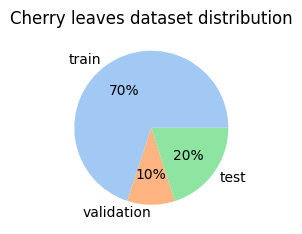

In [14]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

## Import ImageDataGenerator

In [53]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

## Initialize ImageDataGenerator

In [24]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Set Batch Size

In [25]:
batch_size = 16

## Augment training image set

In [33]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image set

Batch shape: (16, 256, 256, 3)


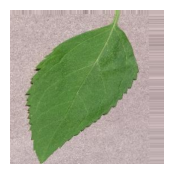

Batch shape: (16, 256, 256, 3)


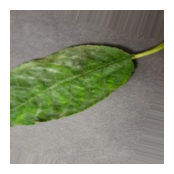

Batch shape: (16, 256, 256, 3)


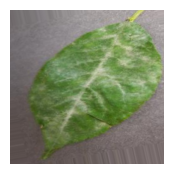

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

for _ in range(3):
    img_batch, label_batch = next(train_set)
    print("Batch shape:", img_batch.shape)
    img = img_batch[0]
    if img.max() > 1:
        img = img.astype("float32") / 255.0
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

## Augment validation image set

In [42]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented validation image set

(16, 256, 256, 3)


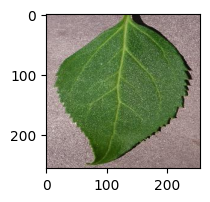

(16, 256, 256, 3)


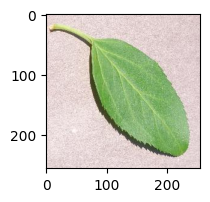

(16, 256, 256, 3)


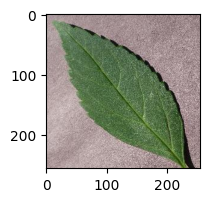

In [46]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = next(validation_set)
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Augment test image set

In [47]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented test image set

(16, 256, 256, 3)


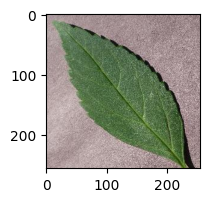

(16, 256, 256, 3)


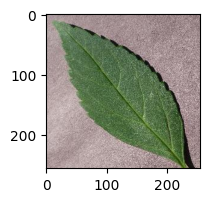

(16, 256, 256, 3)


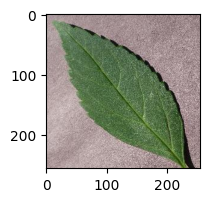

In [49]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    imgs, labels = next(test_set)
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [50]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']